In [4]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, stddev, mean, lit, lead, min as spark_min, max as spark_max
from pyspark.sql.functions import lag, when, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import pandas as pd

In [2]:
# Initialize SparkSession
spark = SparkSession.builder.appName("Stock Data Analysis").getOrCreate()

In [ ]:
# Load dataset and filter
all_df = spark.read.csv("nasdaq100.csv", header=True, inferSchema=True)
all_df = all_df.filter((col("date") <= "2022-12-31"))

In [27]:
# Inspection of data
descriptive_cols = ["close", "open", "high", "low"]
for colname in descriptive_cols:
    all_df.select(colname).describe().show()

+-------+------------------+
|summary|             close|
+-------+------------------+
|  count|            260460|
|   mean|114.62982499216753|
| stddev|202.53754453553674|
|    min|           1.45533|
|    max|           2703.26|
+-------+------------------+

+-------+------------------+
|summary|              open|
+-------+------------------+
|  count|            260460|
|   mean| 114.6305890778235|
| stddev|202.63309373748703|
|    min|             1.452|
|    max|            2680.0|
+-------+------------------+

+-------+------------------+
|summary|              high|
+-------+------------------+
|  count|            260460|
|   mean|116.13291202979387|
| stddev|205.25549946310088|
|    min|           1.48467|
|    max|           2715.66|
+-------+------------------+

+-------+------------------+
|summary|               low|
+-------+------------------+
|  count|            260460|
|   mean|113.07392644674734|
| stddev|199.84585491130093|
|    min|           1.40733|
|    max|  

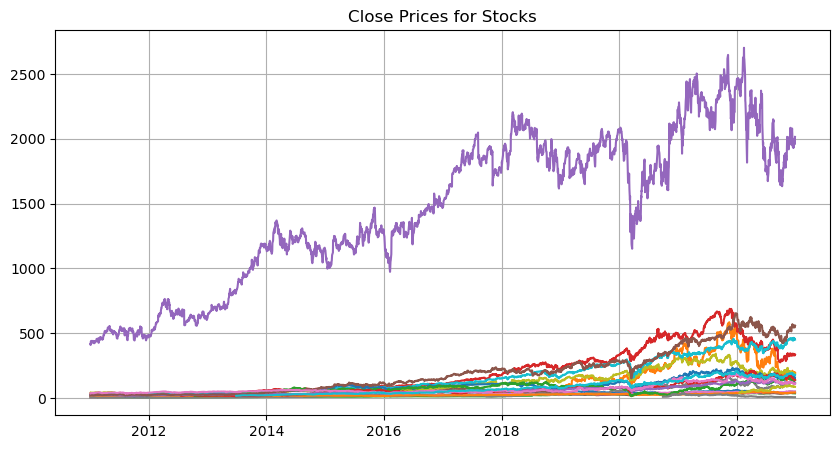

In [10]:
# Plotting raw and log-transformed close prices for sample tickers
pandas_df = all_df.toPandas()
unique_tickers = pandas_df['ticker'].unique()

plt.figure(figsize=(10, 5))
for idx, ticker in enumerate(unique_tickers):
    if idx % 5 == 0:
        ticker_df = pandas_df[pandas_df['ticker'] == ticker]
        plt.plot(ticker_df['date'], ticker_df['close'])
plt.title('Close Prices for Stocks'); 
plt.grid(True); 
plt.show()

In [11]:
# Split data into periods
train_df = all_df.filter(col("date") <= "2016-12-31")
test_period = all_df.filter((col("date") >= "2017-01-01") & (col("date") <= "2017-12-31"))
trade_war_period = all_df.filter((col("date") >= "2018-01-01") & (col("date") <= "2019-12-31"))
covid_period = all_df.filter((col("date") >= "2020-02-01") & (col("date") <= "2020-08-31"))
ukraine_period = all_df.filter((col("date") >= "2022-02-01") & (col("date") <= "2022-12-31"))

In [13]:
# Feature Engineering Function
def create_dataset_spark(df):
    window_spec_5 = Window.partitionBy("ticker").orderBy("date").rowsBetween(-4, 0)
    window_spec_10 = Window.partitionBy("ticker").orderBy("date").rowsBetween(-9, 0)
    window_spec = Window.partitionBy("ticker").orderBy("date")

    df = df.withColumn("ma_5", avg("close").over(window_spec_5)) \
           .withColumn("ma_10", avg("close").over(window_spec_10)) \
           .withColumn("volatility_5", stddev("close").over(window_spec_5)) \
           .withColumn("volatility_10", stddev("close").over(window_spec_10)) \
           .withColumn("close_lag1", lag("close", 1).over(window_spec)) \
           .withColumn("open_lag1", lag("open", 1).over(window_spec)) \
           .withColumn("high_lag1", lag("high", 1).over(window_spec)) \
           .withColumn("low_lag1", lag("low", 1).over(window_spec)) \
           .withColumn("return_open_close", (col("close") - col("open")) / col("open")) \
           .withColumn("return_high_low", (col("high") - col("low")) / col("open")) \
           .withColumn("return_close_lag1", (col("close") - col("close_lag1")) / col("close_lag1")) \
           .withColumn("label_regress", lead("close", 1).over(window_spec)) \
           .withColumn("label_class", when(col("label_regress") > col("close"), 1).otherwise(0)) \
           .withColumn("label_return", (col("label_regress") - col("close")) / col("close"))

    feature_columns = ["open", "high", "low", "close", "ma_5", "ma_10", "volatility_5", "volatility_10",
                       "close_lag1", "open_lag1", "high_lag1", "low_lag1",
                       "return_open_close", "return_high_low", "return_close_lag1"]

    df = df.dropna(subset=feature_columns + ['label_regress', 'label_class', 'label_return'])
    assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
    df = assembler.transform(df)
    return df.select('features', 'label_regress', 'label_class', 'label_return')

In [14]:
# Create training and test datasets
train_sdf = create_dataset_spark(train_df)
test_sdf = create_dataset_spark(test_period)
trade_war = create_dataset_spark(trade_war_period)
covid = create_dataset_spark(covid_period)
ukraine = create_dataset_spark(ukraine_period)

In [15]:
# Feature Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(train_sdf)
train_sdf = scaler_model.transform(train_sdf)
test_sdf = scaler_model.transform(test_sdf)
trade_war = scaler_model.transform(trade_war)
covid = scaler_model.transform(covid)
ukraine = scaler_model.transform(ukraine)


Training Linear Regression...
Linear Regression RMSE during Training Period: 2.425775076420925
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|       10.169|10.082040784367997|
|       10.161|10.158536809311421|
+-------------+------------------+
only showing top 2 rows



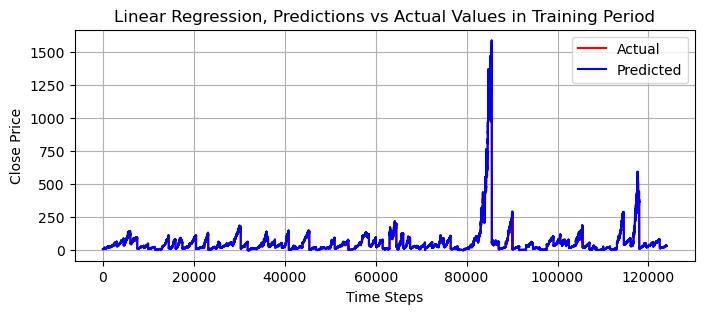

Linear Regression RMSE during Stable Period: 3.2952527430196485
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      27.2867|27.15140029542622|
|      27.5858|27.29365502400841|
+-------------+-----------------+
only showing top 2 rows



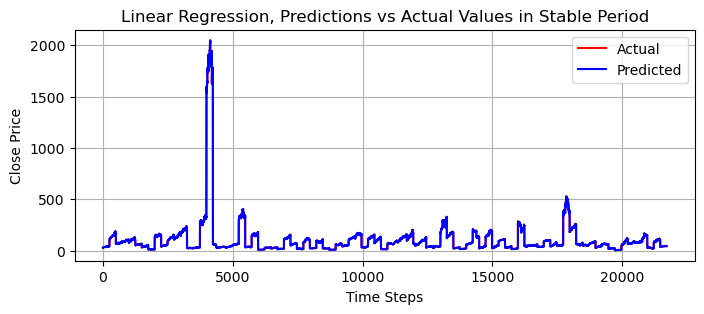

Linear Regression RMSE during Trade War Period: 4.26929274899728
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      41.1366| 40.93779750409024|
|      41.6001|41.179905532132906|
+-------------+------------------+
only showing top 2 rows



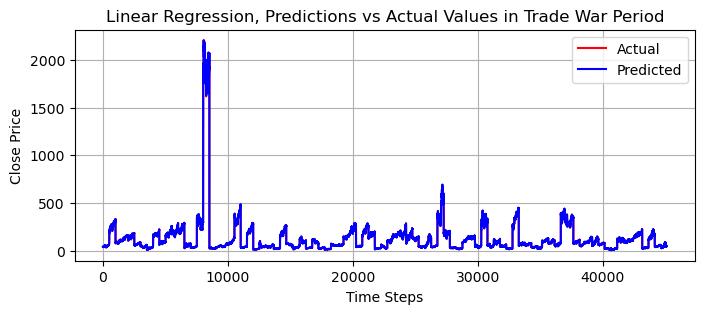

Linear Regression RMSE during COVID Period: 8.436337158219098
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|78.39888917091139|
|      79.6511|78.78156209820531|
+-------------+-----------------+
only showing top 2 rows



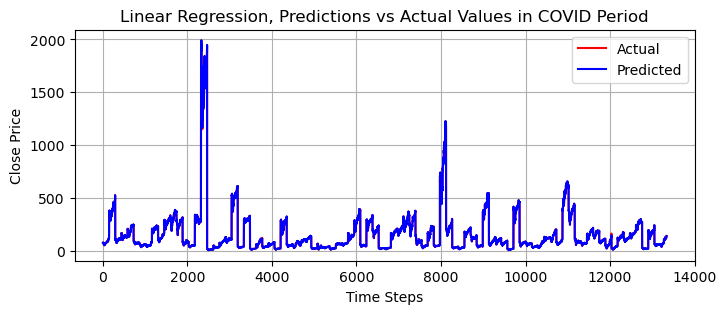

Linear Regression RMSE during Ukraine Period: 9.72962279695246
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      171.906|174.75415896400344|
|      171.616|171.55758325867512|
+-------------+------------------+
only showing top 2 rows



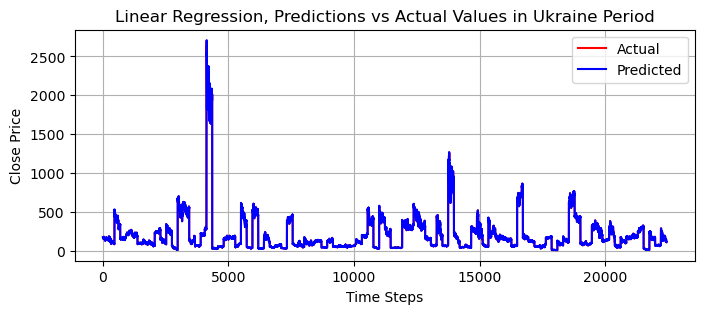


Training GBT Regressor...
GBT Regressor RMSE during Training Period: 46.13817799338388
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|       10.169|9.406853272367119|
|       10.161| 9.46155291773745|
+-------------+-----------------+
only showing top 2 rows



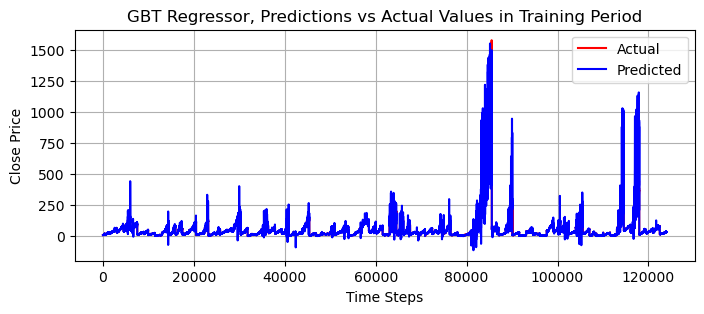

GBT Regressor RMSE during Stable Period: 104.7536961702255
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      27.2867|27.24607088436414|
|      27.5858|27.24607088436414|
+-------------+-----------------+
only showing top 2 rows



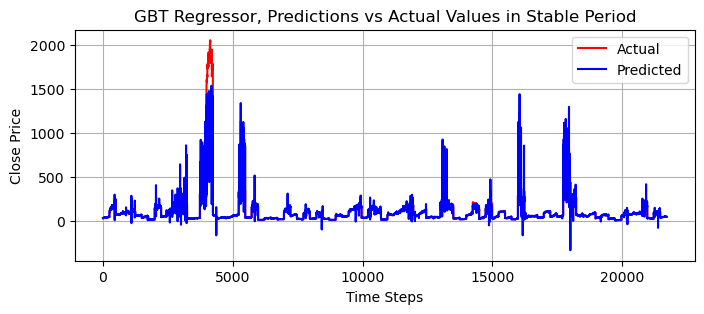

GBT Regressor RMSE during Trade War Period: 142.9359938383327
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.22426396459253|
|      41.6001|41.22426396459253|
+-------------+-----------------+
only showing top 2 rows



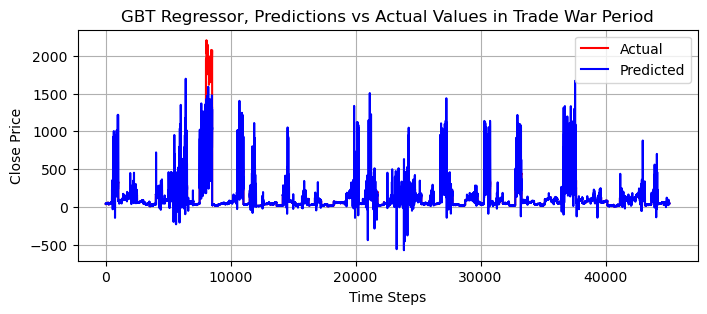

GBT Regressor RMSE during COVID Period: 163.08995917263306
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|81.44132439158541|
|      79.6511|80.19471858120203|
+-------------+-----------------+
only showing top 2 rows



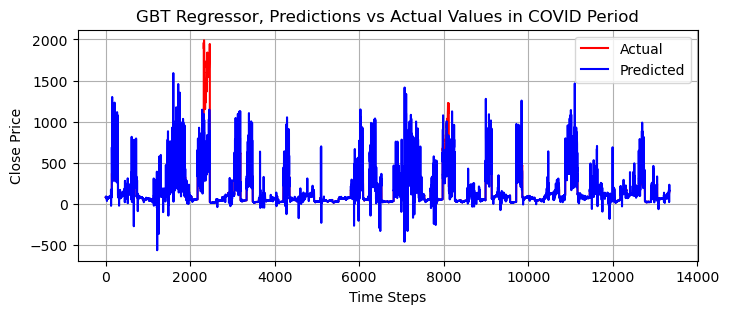

GBT Regressor RMSE during Ukraine Period: 205.00317529044366
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      171.906|152.41565902841484|
|      171.616|149.80232549310517|
+-------------+------------------+
only showing top 2 rows



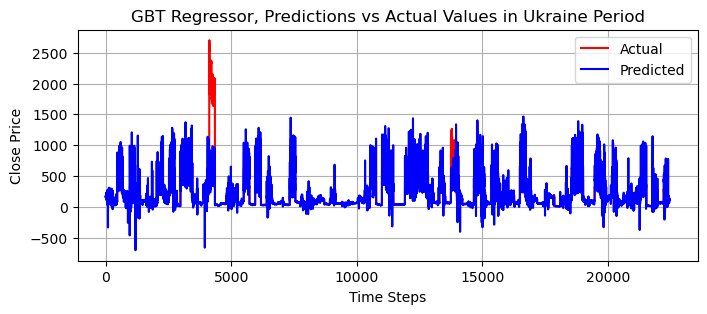


Training Random Forest Regressor...
Random Forest Regressor RMSE during Training Period: 52.662113743376956
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|       10.169|12.184774059611447|
|       10.161|12.184774059611447|
+-------------+------------------+
only showing top 2 rows



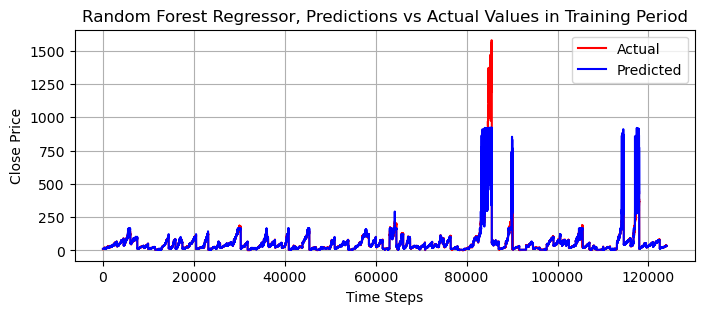

Random Forest Regressor RMSE during Stable Period: 114.95502489516146
+-------------+---------------+
|label_regress|     prediction|
+-------------+---------------+
|      27.2867|26.023260189472|
|      27.5858|26.023260189472|
+-------------+---------------+
only showing top 2 rows



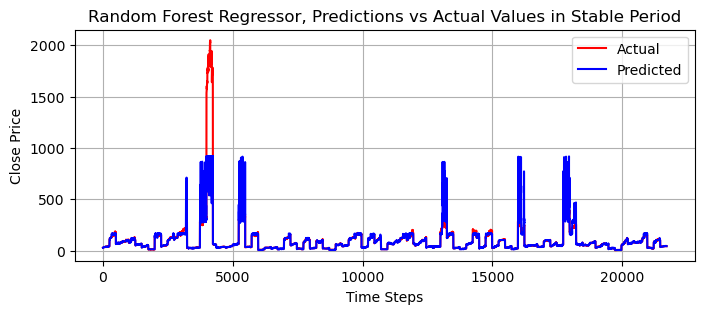

Random Forest Regressor RMSE during Trade War Period: 142.4262032492709
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.99744058160763|
|      41.6001|41.99744058160763|
+-------------+-----------------+
only showing top 2 rows



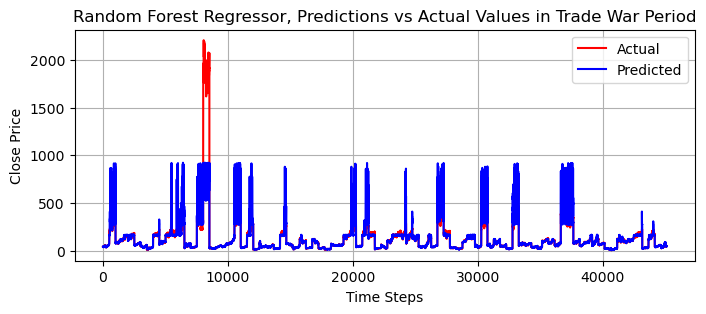

Random Forest Regressor RMSE during COVID Period: 151.1817052666256
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|78.15790666482651|
|      79.6511|78.15790666482651|
+-------------+-----------------+
only showing top 2 rows



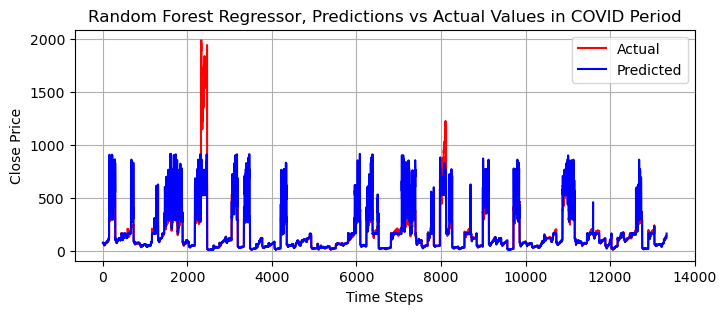

Random Forest Regressor RMSE during Ukraine Period: 190.57916076541719
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      171.906|157.32724596462864|
|      171.616| 157.5922143919803|
+-------------+------------------+
only showing top 2 rows



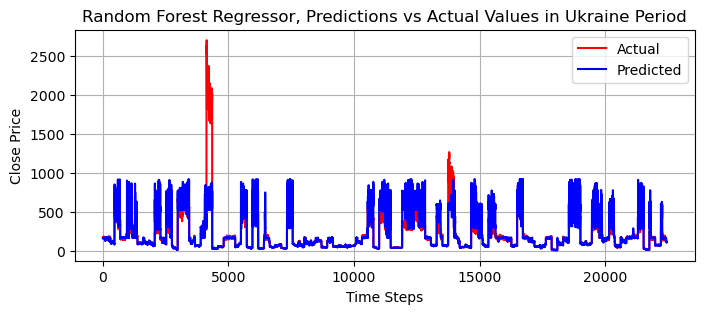


Training Decision Tree Regressor...
Decision Tree Regressor RMSE during Training Period: 51.917443647075935
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|       10.169|12.229653172247843|
|       10.161|12.229653172247843|
+-------------+------------------+
only showing top 2 rows



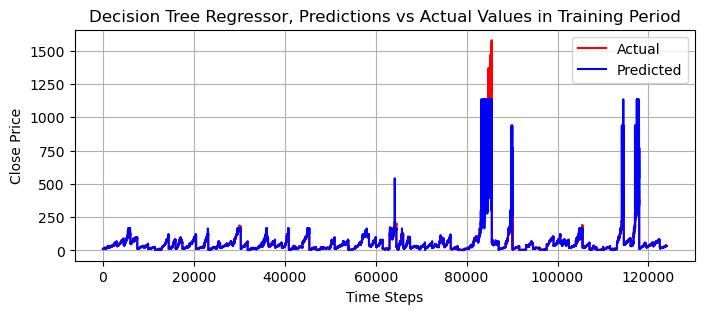

Decision Tree Regressor RMSE during Stable Period: 104.8161439114571
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      27.2867|25.750158254716975|
|      27.5858|25.750158254716975|
+-------------+------------------+
only showing top 2 rows



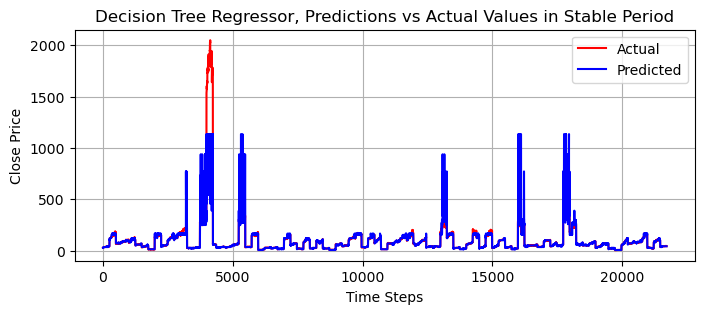

Decision Tree Regressor RMSE during Trade War Period: 140.02937964009107
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.34880065637066|
|      41.6001|41.34880065637066|
+-------------+-----------------+
only showing top 2 rows



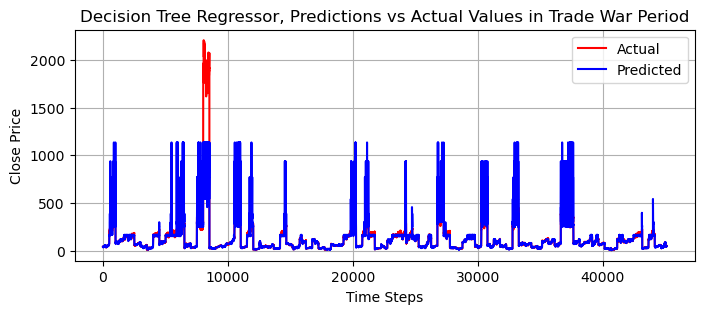

Decision Tree Regressor RMSE during COVID Period: 155.44877759982933
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      78.7269|80.14414409413857|
|      79.6511|80.14414409413857|
+-------------+-----------------+
only showing top 2 rows



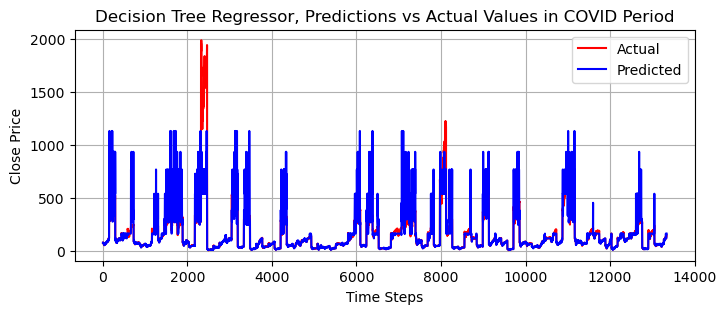

Decision Tree Regressor RMSE during Ukraine Period: 195.09428942700683
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      171.906|151.8893277268094|
|      171.616|151.8893277268094|
+-------------+-----------------+
only showing top 2 rows



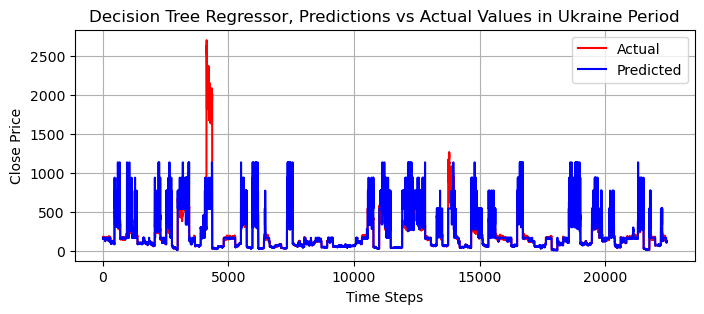

In [16]:
# Train and Evaluate Regressors
regressors = {
    "Linear Regression": LinearRegression(featuresCol="scaled_features", labelCol="label_regress"),
    "GBT Regressor": GBTRegressor(featuresCol="scaled_features", labelCol="label_regress", stepSize=0.5, seed=42),
    "Random Forest Regressor": RandomForestRegressor(featuresCol="scaled_features", labelCol="label_regress", numTrees=100, seed=42),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol="scaled_features", labelCol="label_regress")
}

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    reg_model = model.fit(train_sdf)
    reg_eval = RegressionEvaluator(predictionCol = "prediction" , labelCol="label_regress", metricName="rmse")
    for period_name, period_df in zip(["Training Period", "Stable Period", "Trade War Period", "COVID Period", "Ukraine War Period"], [train_sdf, test_sdf, trade_war, covid, ukraine]):
        preds = reg_model.transform(period_df)
        rmse = reg_eval.evaluate(preds)
        print(f"{name} RMSE during {period_name}: {rmse}")
        preds.select("label_regress", "prediction").show(2)

        # Collect results for plotting
        preds_pd = preds.select('label_regress', 'prediction').toPandas()        
        
        # Plot
        plt.figure(figsize=(8, 3))
        plt.plot(range(len(preds_pd)), preds_pd['label_regress'], label='Actual', color='red')
        plt.plot(range(len(preds_pd)), preds_pd['prediction'], label='Predicted', color='blue')
        plt.xlabel('Time Steps')
        plt.ylabel('Close Price')
        plt.title(f"{name}, Predictions vs Actual Values in {period_name}")
        plt.legend()
        plt.grid(True)
        plt.show()


Training Linear Regression...
Linear Regression RMSE during Training Period: 2.425775076420925
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|       10.169|10.082040784367997|
|       10.161|10.158536809311421|
+-------------+------------------+
only showing top 2 rows

Linear Regression RMSE during Stable Period: 3.2952527430196485
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      27.2867|27.15140029542622|
|      27.5858|27.29365502400841|
+-------------+-----------------+
only showing top 2 rows

Linear Regression RMSE during Trade War Period: 4.26929274899728
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      41.1366| 40.93779750409024|
|      41.6001|41.179905532132906|
+-------------+------------------+
only showing top 2 rows

Linear Regression RMSE during COVID Period: 8.436337158219098
+-------------

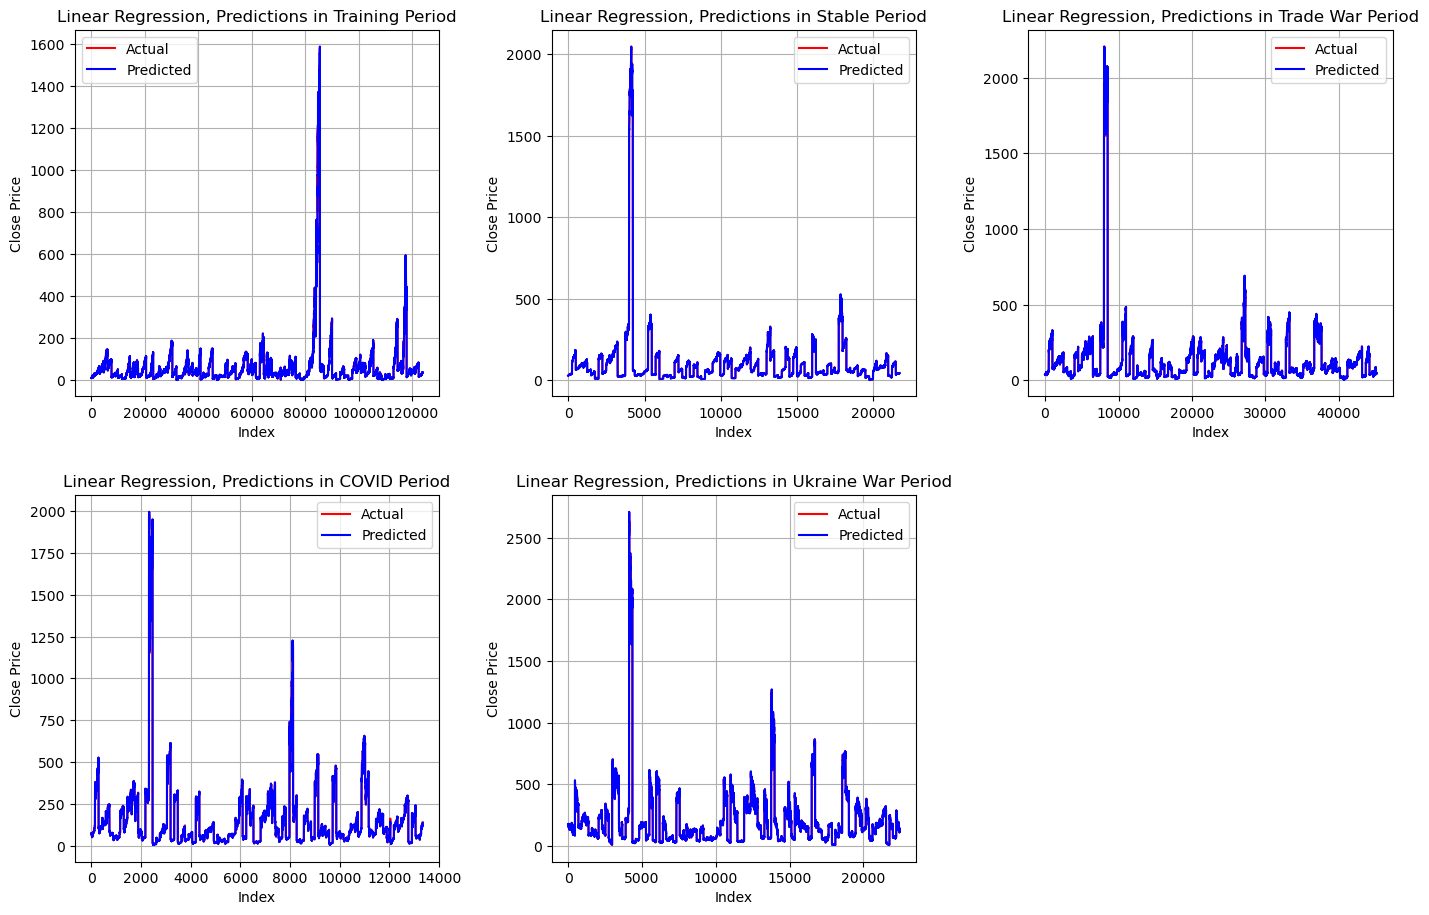


Training GBT Regressor...
GBT Regressor RMSE during Training Period: 46.13817799338388
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|       10.169|9.406853272367119|
|       10.161| 9.46155291773745|
+-------------+-----------------+
only showing top 2 rows

GBT Regressor RMSE during Stable Period: 104.7536961702255
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      27.2867|27.24607088436414|
|      27.5858|27.24607088436414|
+-------------+-----------------+
only showing top 2 rows

GBT Regressor RMSE during Trade War Period: 142.9359938383327
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.22426396459253|
|      41.6001|41.22426396459253|
+-------------+-----------------+
only showing top 2 rows

GBT Regressor RMSE during COVID Period: 163.08995917263306
+-------------+-----------------+
|label_regr

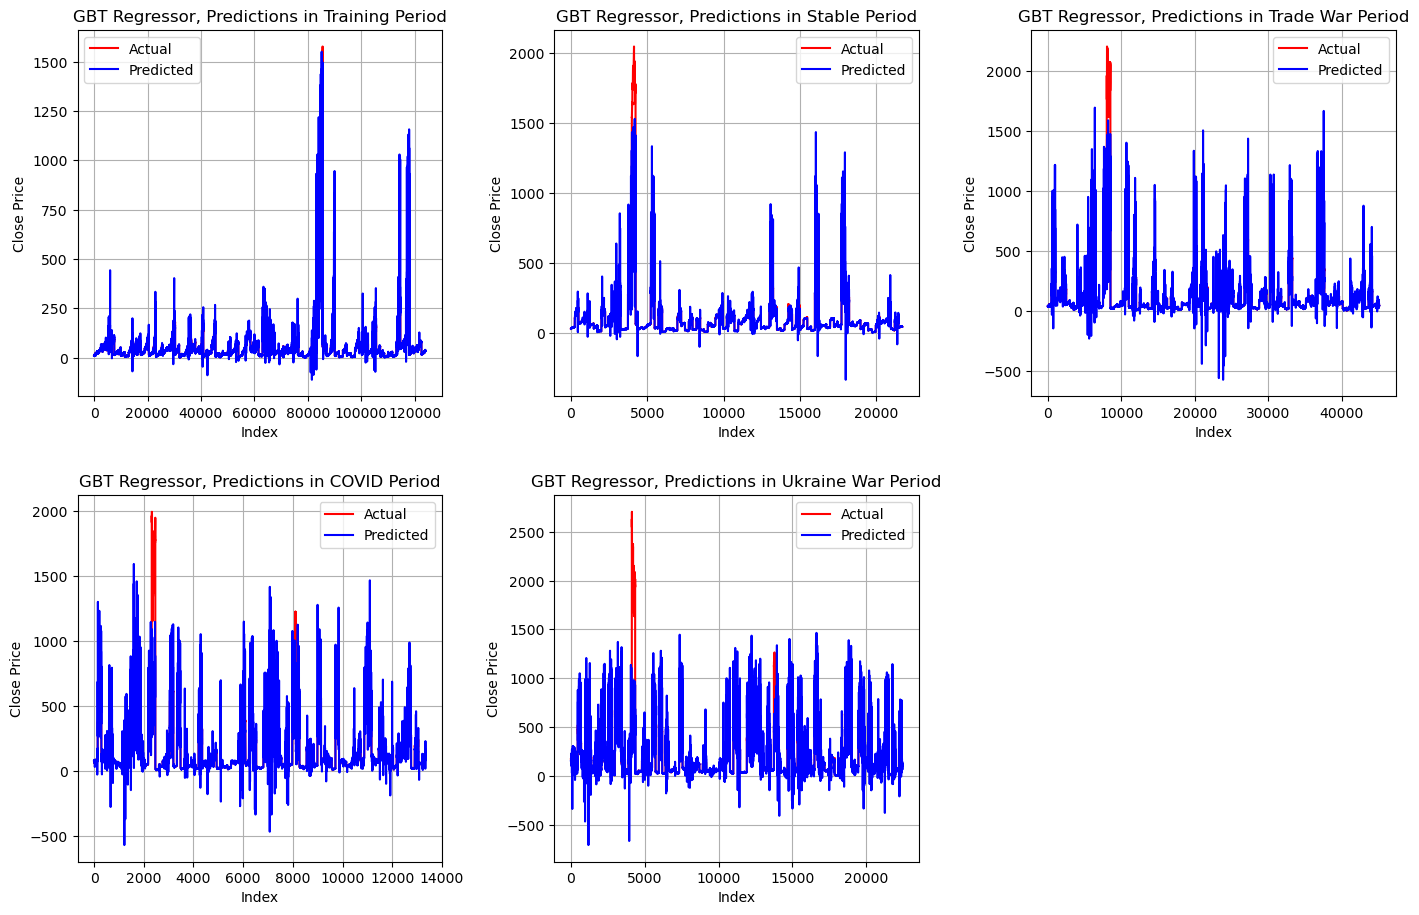


Training Random Forest Regressor...
Random Forest Regressor RMSE during Training Period: 52.662113743376956
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|       10.169|12.184774059611447|
|       10.161|12.184774059611447|
+-------------+------------------+
only showing top 2 rows

Random Forest Regressor RMSE during Stable Period: 114.95502489516146
+-------------+---------------+
|label_regress|     prediction|
+-------------+---------------+
|      27.2867|26.023260189472|
|      27.5858|26.023260189472|
+-------------+---------------+
only showing top 2 rows

Random Forest Regressor RMSE during Trade War Period: 142.4262032492709
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.99744058160763|
|      41.6001|41.99744058160763|
+-------------+-----------------+
only showing top 2 rows

Random Forest Regressor RMSE during COVID Period: 151.1817052666256


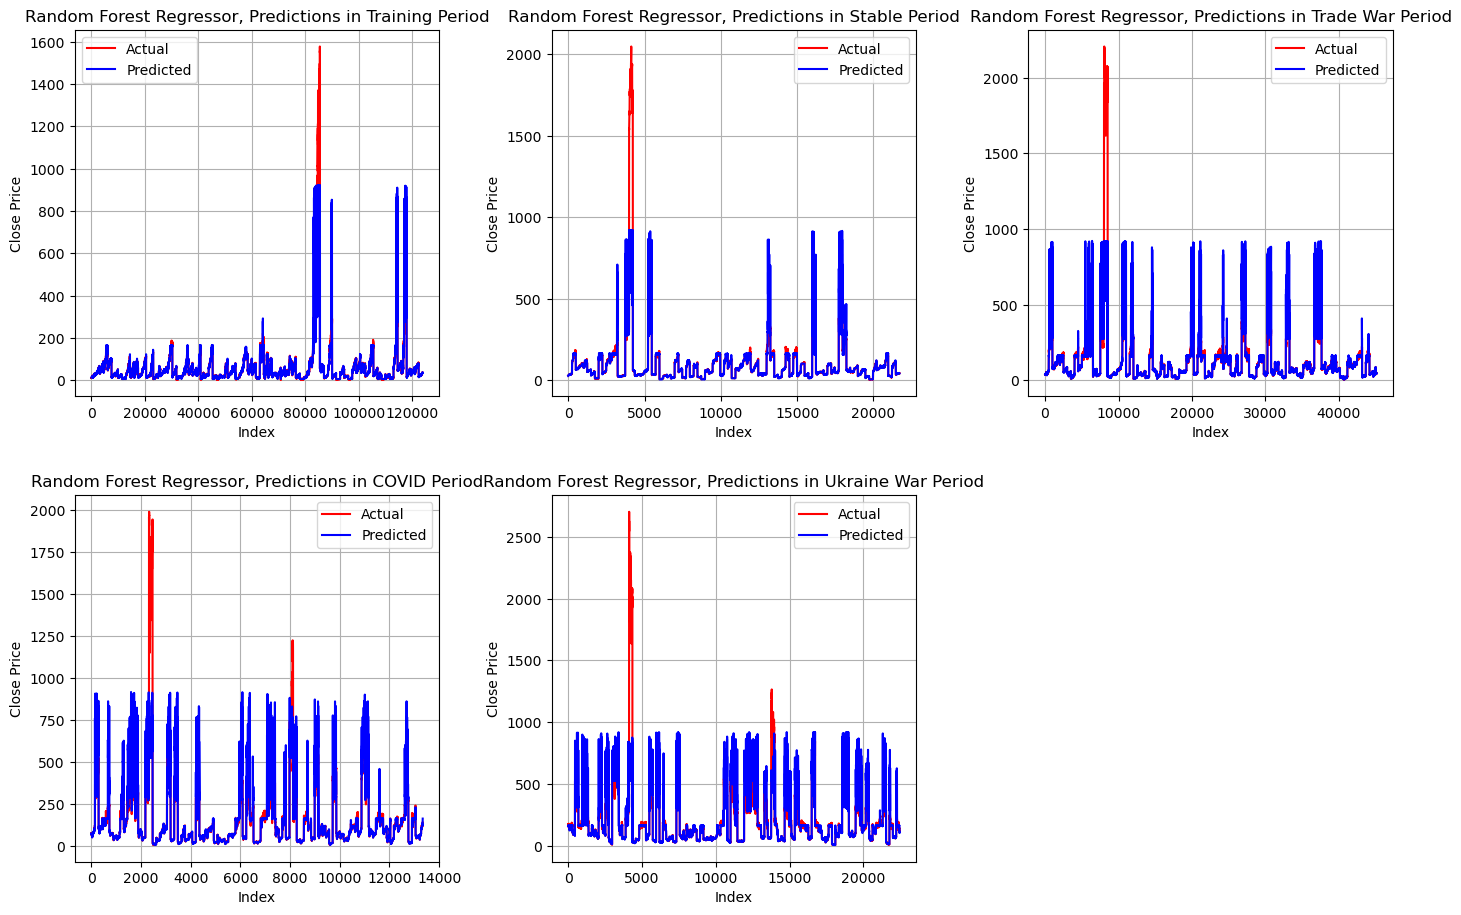


Training Decision Tree Regressor...
Decision Tree Regressor RMSE during Training Period: 51.917443647075935
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|       10.169|12.229653172247843|
|       10.161|12.229653172247843|
+-------------+------------------+
only showing top 2 rows

Decision Tree Regressor RMSE during Stable Period: 104.8161439114571
+-------------+------------------+
|label_regress|        prediction|
+-------------+------------------+
|      27.2867|25.750158254716975|
|      27.5858|25.750158254716975|
+-------------+------------------+
only showing top 2 rows

Decision Tree Regressor RMSE during Trade War Period: 140.02937964009107
+-------------+-----------------+
|label_regress|       prediction|
+-------------+-----------------+
|      41.1366|41.34880065637066|
|      41.6001|41.34880065637066|
+-------------+-----------------+
only showing top 2 rows

Decision Tree Regressor RMSE during COVID Period: 

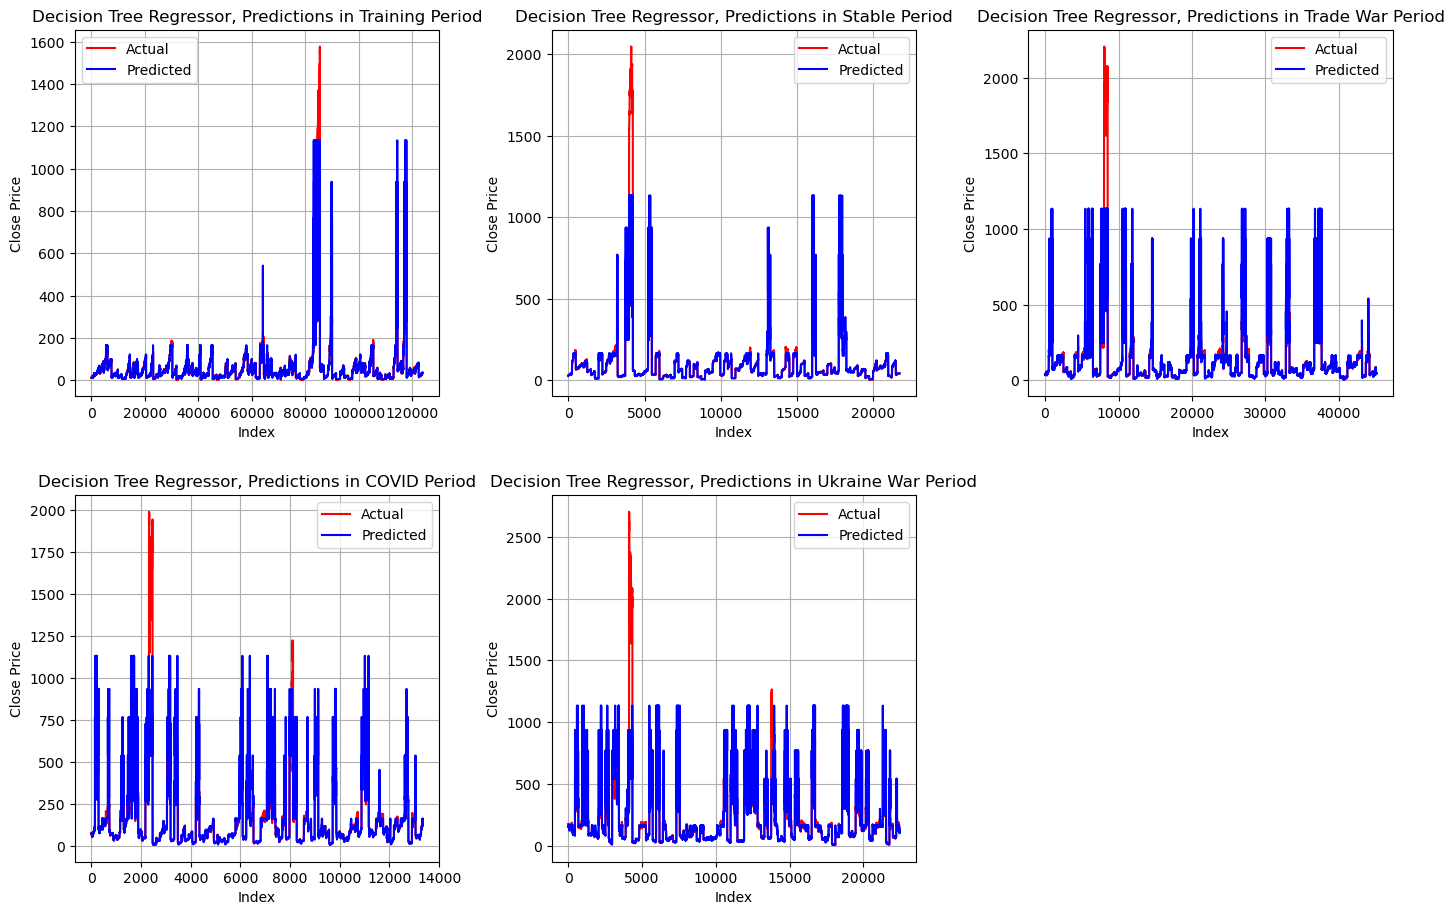

In [17]:
# Train and Evaluate Regressors
regressors = {
    "Linear Regression": LinearRegression(featuresCol="scaled_features", labelCol="label_regress"),
    "GBT Regressor": GBTRegressor(featuresCol="scaled_features", labelCol="label_regress", stepSize=0.5, seed=42),
    "Random Forest Regressor": RandomForestRegressor(featuresCol="scaled_features", labelCol="label_regress", numTrees=100, seed=42),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol="scaled_features", labelCol="label_regress")
}

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    reg_model = model.fit(train_sdf)
    reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="label_regress", metricName="rmse")
    
    # Initialize a 3x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 
    fig.tight_layout(pad=5.0)
    
    for i, (period_name, period_df) in enumerate(zip(["Training Period", "Stable Period", "Trade War Period", "COVID Period", "Ukraine War Period"], 
                                                     [train_sdf, test_sdf, trade_war, covid, ukraine])):
        preds = reg_model.transform(period_df)
        rmse = reg_eval.evaluate(preds)
        print(f"{name} RMSE during {period_name}: {rmse}")
        preds.select("label_regress", "prediction").show(2)

        # Collect results for plotting
        preds_pd = preds.select('label_regress', 'prediction').toPandas()
        
        # Determine subplot position dynamically
        row, col = divmod(i, 3)  # Find row and column position
        axes[row, col].plot(range(len(preds_pd)), preds_pd['label_regress'], label='Actual', color='red')
        axes[row, col].plot(range(len(preds_pd)), preds_pd['prediction'], label='Predicted', color='blue')
        axes[row, col].set_xlabel('Index')
        axes[row, col].set_ylabel('Close Price')
        axes[row, col].set_title(f"{name}, Predictions in {period_name}")
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    # Turn off any unused subplots in the grid (if < 9 plots)
    for j in range(len(axes.flatten())):
        if j >= len(["Training Period", "Stable Period", "Trade War Period", "COVID Period", "Ukraine Period"]):
            axes.flatten()[j].axis("off")
    
    # Display the entire grid figure
    plt.show()